In [121]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import os
from tqdm import tqdm_notebook as tqdm
from shapely.geometry import LineString
from shapely.geometry import Point
from math import radians, cos, sin, asin, sqrt

In [122]:
path='./data/'

In [123]:
TB=pd.read_csv(path+'TB_2019-10-09.csv')

In [165]:
TB[0:2]

,MODULEID,lat,long,mr_name,time
0,2738,53.504964,49.295360,Маршрут 14,2019-10-09T03:12:46Z
1,2738,53.504816,49.296884,Маршрут 14,2019-10-09T03:12:59Z


In [125]:
#TB=TB.rename(columns={0: 'MODULEID' , 6:'long' , 7:'lat', 1:'mr_name', 5:'time'})

In [126]:
TB=TB[['MODULEID' ,'lat', 'long' ,'mr_name', 'time']]

In [127]:
#perexod=pd.read_csv(path+'tol_marsh_TB.csv', sep=';',encoding='windows-1251')
#perexod=perexod[['mr_id','mr_name']]
#TB1=TB1.merge(perexod,on='mr_name')

## Вырезаем точки трека,близкие к остановкам для автобусов ПАТП:

In [128]:
# Cчитываем файлы, содержащие треки за 28 сентября 2020 года
df_4 = TB

# Считываем файл с последовательным списком остановок на маршрутах ('stop_seq.csv')
stop_seq = pd.read_csv(path + 'stop_seq_TB.csv', sep = ';', encoding = 'utf8')

In [129]:
stop_seq[0:2]

,rc_orderby,ssId,ss_lat,ss_long,rl_id,mr_id,route_number
0,1,stop__9854762,53.476261,49.349212,3473582645,3473581925,1
1,2,stop__9854369,53.478978,49.352483,3473582645,3473581925,1


In [130]:
df_4[0:2]

,MODULEID,lat,long,mr_name,time
0,2738,53.504964,49.295360,Маршрут 14,2019-10-09T03:12:46Z
1,2738,53.504816,49.296884,Маршрут 14,2019-10-09T03:12:59Z


In [131]:
stop_seq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457 entries, 0 to 456
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   rc_orderby    457 non-null    int64  
 1   ssId          457 non-null    object 
 2   ss_lat        457 non-null    float64
 3   ss_long       457 non-null    float64
 4   rl_id         457 non-null    int64  
 5   mr_id         457 non-null    int64  
 6   route_number  457 non-null    int64  
dtypes: float64(2), int64(4), object(1)
memory usage: 25.1+ KB


In [132]:
df_4=df_4[['MODULEID','lat','long','time','mr_name']]
df_4['route_number']=df_4['mr_name'].str.replace('Маршрут ','').astype('int64')
#df_4['lat']=df_4['lat'].astyostr.replace(',','.').astype(float)
#df_4['long']=df_4['long'].str.replace(',','.').astype(float)

<ipython-input-132-dc031a474cf7>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_4['route_number']=df_4['mr_name'].str.replace('Маршрут ','').astype('int64')


In [133]:
df_4=df_4[['MODULEID','lat','long','time','route_number']]

In [134]:
df_4_gpd = gpd.GeoDataFrame(df_4,  geometry = [Point(xy) for xy in zip(df_4['long'], df_4['lat'])])
df_4_gpd.crs='epsg:4326'

In [135]:
stop_seq_gpd = gpd.GeoDataFrame(stop_seq,  geometry = [Point(xy) for xy in zip(stop_seq['ss_long'], stop_seq['ss_lat'])])
stop_seq_gpd.crs='epsg:4326'

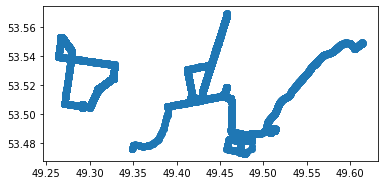

In [136]:
df_4_gpd.plot()

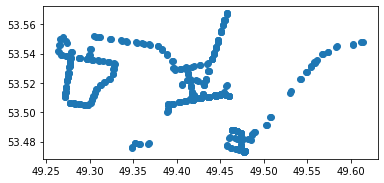

In [137]:
stop_seq_gpd.plot()

In [138]:
#пересекли треки с остановками с буфером 100 метров
stops_with_buff = stop_seq_gpd.to_crs('epsg:32640')
stops_with_buff.geometry = stops_with_buff.geometry.buffer(100)
stops_with_buff = stops_with_buff.to_crs('epsg:4326')
df_4_small=gpd.sjoin(df_4_gpd, stops_with_buff, how='left', op='within', lsuffix='left', rsuffix='right')

In [139]:
df_4_small=df_4_small[df_4_small['ssId'].notna()]

In [140]:
len(df_4_gpd)

107369

In [141]:
len(df_4_small)

206381

Выбираем только остановки внутри одного маршрута

In [142]:
df_4_small=df_4_small[df_4_small['route_number_left']==df_4_small['route_number_right']]

In [143]:
len(df_4_small)

67864

In [144]:
# Расчёт растояния между координатами
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    
    # haversine formula 
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371 * 1000 # Radius of earth in kilometers. Use 3956 for miles
    return c * r

In [145]:
df_4_small['len'] = 0
df_4_small['len'] = df_4_small.apply(lambda row: haversine(row.long, row.lat, row.ss_long, row.ss_lat), axis = 1)

In [146]:
df_4_small['time2']=pd.to_datetime(df_4_small['time'])

In [147]:

df_4_small['hour']=df_4_small['time2'].dt.hour
df_4_small['min']=df_4_small['time2'].dt.minute
df_4_small['sec']=df_4_small['time2'].dt.second
df_4_small['time']=(df_4_small['hour'].astype(int))*3600+(df_4_small['min'].astype(int))*60+df_4_small['sec'].astype(int)

In [148]:
df_4_small[0:2]

,MODULEID,lat,long,time,route_number_left,geometry,index_right,rc_orderby,ssId,ss_lat,ss_long,rl_id,mr_id,route_number_right,len,time2,hour,min,sec
0,2738,53.504964,49.295360,11566,14,POINT (49.29536 53.50496),331.0,1.0,stop__9854170,53.504967,49.294216,2.227623e+09,2.227623e+09,14.0,75.68572,2019-10-09 03:12:46+00:00,3,12,46
1,2738,53.504816,49.296884,11579,14,POINT (49.29688 53.50482),332.0,2.0,stop__9854169,53.504627,49.298312,2.227623e+09,2.227623e+09,14.0,96.71938,2019-10-09 03:12:59+00:00,3,12,59


In [149]:
df_4_small2=df_4_small[['mr_id','rl_id','rc_orderby','ssId','MODULEID','time','len','geometry','ss_lat','ss_long','route_number_left']]

In [150]:
df_4_small2.to_csv('for_perl_TB_2019-10-09.csv',index=False,sep=';')

## Формируем выгрузку для привязки валидаций!

In [151]:
df_4_small3=df_4_small2

In [152]:
df_4_small3['time_in_sec']=df_4_small3['time']

C:\Users\user\anaconda3\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [153]:
df_4_small3=df_4_small3.sort_values(by=['mr_id','rl_id','MODULEID','time_in_sec','rc_orderby'])

In [154]:
df_4_small3['time_in_sec2']=df_4_small3.groupby(['mr_id','rl_id','MODULEID'])['time_in_sec'].shift(-1).astype('Int64')

Убираем строки, которые идут друг за дружкой с одной и той же остановкой

In [155]:
df_4_small3['rc_orderby2'] = df_4_small3.groupby(['mr_id','rl_id','MODULEID'])['rc_orderby'].shift(-1).astype('Int64')
df_4_part=df_4_small3[~(df_4_small3['rc_orderby2']==df_4_small3['rc_orderby'])]
df_4_part['time_start']=df_4_part['time_in_sec']

C:\Users\user\anaconda3\lib\site-packages\geopandas\geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [156]:
df_4_part['time_finish'] = df_4_part.groupby(['mr_id','rl_id','MODULEID'])['time_start'].shift(-1).astype('Int64')

In [157]:
df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','len','ssId','time','len','time_start','time_finish','ss_lat','ss_long','geometry']]

## Выбираем только те последовательности, где между двумя посл. отметками прошло не больше 40 минут

In [158]:
df_4_part['delta']=df_4_part['time_finish']-df_4_part['time_start']
df_4_part['delta2']=df_4_part.groupby(['mr_id','rl_id','MODULEID'])['delta'].shift(1).astype('Int64')
df_4_part=df_4_part[((df_4_part['delta']<60*40)&(df_4_part['delta']>0))|(df_4_part['delta'].isna())].\
append(df_4_part[(df_4_part['delta2']<60*40)&(df_4_part['delta2']>0)]).\
append(df_4_part[df_4_part['rc_orderby']==1]) #добавили конечные (там отстои могут быть очень долго)

df_4_part=df_4_part.sort_values(by=['mr_id','rl_id','MODULEID','time_start','rc_orderby'])

df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','len','ssId','time','time_start','time_finish','ss_lat','ss_long','geometry']].drop_duplicates()

In [159]:
df_4_part[0:5]

,mr_id,rl_id,MODULEID,rc_orderby,len,len,ssId,time,time_start,time_finish,ss_lat,ss_long,geometry
39675,2.227623e+09,2.278607e+09,2958,2.0,85.140601,85.140601,stop__9854705,39633,39633,39691,53.477451,49.474193,POINT (49.47416 53.47822)
39679,2.227623e+09,2.278607e+09,2958,3.0,13.259377,13.259377,stop__9854703,39691,39691,39773,53.480778,49.474305,POINT (49.47419 53.48088)
39685,2.227623e+09,2.278607e+09,2958,4.0,48.488333,48.488333,stop__9854681,39773,39773,39894,53.484178,49.474376,POINT (49.47431 53.48461)
39706,2.227623e+09,2.278607e+09,2958,5.0,16.785850,16.785850,stop__9854335,39894,39894,39934,53.487297,49.469209,POINT (49.46898 53.48723)
39712,2.227623e+09,2.278607e+09,2958,6.0,21.439911,21.439911,stop__9854337,39934,39934,40208,53.487696,49.465350,POINT (49.46505 53.48762)


## Выбираем только те последовательности, где номера остановок растут 

In [160]:
len(df_4_part)

20449

In [161]:
df_4_part['rc_orderby2'] = df_4_part.groupby(['mr_id','rl_id','MODULEID'])['rc_orderby'].shift(-1).astype('Int64')
df_4_part=df_4_part[(df_4_part['rc_orderby2']>df_4_part['rc_orderby'])|(df_4_part['rc_orderby2'].isna())]

In [162]:
df_4_part=df_4_part[['mr_id','rl_id','MODULEID','rc_orderby','len','ssId','time','time_start','time_finish','ss_lat','ss_long','geometry']].drop_duplicates()

In [163]:
df_4_part.to_csv('res_TB_2019-10-09.csv', index=False)